# Génération de données

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from config import *

In [2]:
df_pollen = pd.read_csv("data/boreal_forest/"+CHARCOAL_ID+"_spec.csv")
df_pollen = df_pollen.rename(columns={"Profondeur": "Depth"})
df_pollen.columns = df_pollen.columns.str.strip()
display(df_pollen)

,Depth,Abies,Juniperus,Larix,Picea,Pinus,Tsuga,Acer,Alnus,Betula,...,Myrica,Phytolithe,Poaceae,Rosaceae,Sarcobatus,Thalictrum,Typha,Spore monolete,Spore trilete,Aquatics
0,570,1.095890,0.273973,1.917808,16.712329,53.698630,0.000000,0.000000,1.917808,8.219178,...,0.547945,0.273973,1.369863,0.000000,0.000000,0.000000,0.273973,0.00000,0.000000,0.000000
1,580,0.906344,0.302115,0.604230,13.897281,62.235650,0.302115,0.000000,0.604230,10.574018,...,0.000000,0.000000,1.208459,0.000000,0.000000,0.000000,0.000000,0.60423,0.302115,0.000000
2,590,0.840336,0.840336,1.680672,14.005602,59.383753,0.000000,0.000000,0.560224,9.523810,...,0.280112,0.000000,1.400560,0.000000,0.000000,0.000000,0.280112,0.00000,0.000000,0.000000
3,600,1.056338,0.264085,2.640845,12.147887,52.816901,0.000000,0.000000,5.545775,13.204225,...,0.528169,0.000000,1.584507,0.264085,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,610,1.744186,0.000000,1.744186,16.694352,55.315615,0.000000,0.249169,0.996678,9.219269,...,0.498339,0.000000,4.235880,0.000000,0.000000,0.249169,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1140,0.000000,0.307062,2.456499,25.793245,31.320368,0.000000,0.000000,0.307062,21.494371,...,0.307062,0.000000,3.991812,0.000000,0.000000,0.000000,1.535312,0.00000,0.000000,0.000000
58,1150,0.000000,0.568182,1.136364,13.068182,51.704545,0.000000,0.000000,0.000000,15.909091,...,0.568182,0.000000,5.681818,0.000000,0.284091,0.000000,0.284091,0.00000,0.000000,0.284091
59,1160,0.000000,1.863354,0.621118,10.559006,57.142857,0.000000,0.000000,0.310559,12.422360,...,0.310559,0.000000,3.416149,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
60,1170,0.000000,0.595238,1.785714,17.559524,54.166667,0.000000,0.000000,0.000000,10.119048,...,0.000000,0.000000,3.273810,0.000000,0.000000,0.000000,0.297619,0.00000,0.000000,0.297619


In [3]:
if DEBUG:
    for col in df_pollen.columns:
        if col != "Depth":
            sns.lineplot(df_pollen, x="Depth", y=col)
            plt.show()
            plt.clf()

## Modèle

$$
\frac{dX_s}{dt}
= r_s\,X_s\left(1 - \frac{X_s}{K_s}\right)
+ X_s \sum_{j} a_{j \to s}\,X_j
$$



### Paramètres

#### Selection des espèces utilisées

Ces espèces réelles influenceront chacune des espèces générées

In [4]:
SELECTED_POLLEN = ['Picea', 'Pinus', 'Alnus', 'Betula', 'Quercus', 'Ambrosia']
df_pollen = df_pollen[[c for c in df_pollen.columns if c in SELECTED_POLLEN or c == 'Depth'  ]]
n_pollen = len(SELECTED_POLLEN)

#### Nombre d'espèces générés

In [5]:
N = 1

#### Matrice des interactions et paramètres du modèles

In [6]:
ordre_interactions = 0.03           
A = ordre_interactions*(np.random.random((N,n_pollen))-0.2) ## intéractions positives ou négatives
print(A)
df_A = pd.DataFrame(A, columns=SELECTED_POLLEN)
A = df_A.loc[range(N),SELECTED_POLLEN]

r = 0.08
K = 1.0


[[-0.00386547  0.00700459  0.01516871  0.01588399  0.00311644  0.02213615]]


## Générations des espèces

In [7]:
# effet des autres espèces sur Synth 
df_sorted = df_pollen.sort_values("Depth", ascending=False).reset_index(drop=True)

# colonne Synth initialisée
Synth = np.zeros((N,len(df_sorted)))
Synth[:,0] = 10  # condition initiale ancienne

# intégration dans l'ordre des profondeurs décroissantes
for i in range(1, len(df_sorted)):
    Xt = Synth[:,i-1]
    X_others = df_sorted.loc[i-1, SELECTED_POLLEN].values
    interaction = np.dot(A, X_others)
    dX = r*Xt*(1 - Xt/K) + Xt*interaction
    Synth[:,i] = np.maximum(0, Xt + dX)

# ré-attacher la colonne Synth dans le df initial, réordonné comme avant
for j in range(N):
    df_sorted[f'Synth_{str(j)}'] = Synth[j,:]
df_pollen = df_sorted.sort_values("Depth", ascending=True).reset_index(drop=True)

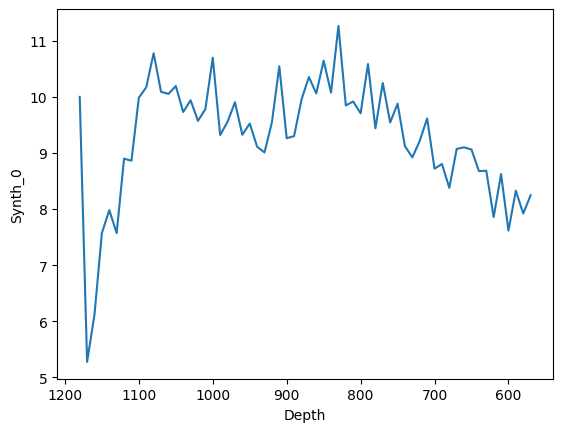

<Figure size 640x480 with 0 Axes>

In [8]:
for col in df_pollen.columns:
    if col[:6] == "Synth_":
        sns.lineplot(df_pollen, x="Depth", y=col)
        plt.gca().invert_xaxis()
        plt.show()
        plt.clf()

## Enregistrement des données

In [9]:
import os

SAVE_DIR = "tmp"

In [10]:
# Sauvegarde des DataFrames
df_pollen[[c for c in df_pollen if "Synth" in c or c == "Depth"]].to_csv(os.path.join(SAVE_DIR, "df_synth.csv"), index=False)
df_A.to_csv(os.path.join(SAVE_DIR, "df_A.csv"), index=False)

print("DataFrames sauvegardés.")

DataFrames sauvegardés.


In [11]:
import json

params = {
    "SELECTED_POLLEN": SELECTED_POLLEN,
    "N": N
}

with open(os.path.join(SAVE_DIR, "parameters.json"), "w") as f:
    json.dump(params, f, indent=4)

print("Paramètres sauvegardés dans parameters.json.")

Paramètres sauvegardés dans parameters.json.


## Lecture des données

In [12]:
import pandas as pd
import os

df_pollen = pd.read_csv(os.path.join(SAVE_DIR, "df_synth.csv"))
df_A = pd.read_csv(os.path.join(SAVE_DIR, "df_A.csv"))

print("DataFrames rechargés.")
df_pollen.head(), df_A.head()


DataFrames rechargés.


(   Depth   Synth_0
 0    570  8.245924
 1    580  7.921784
 2    590  8.327267
 3    600  7.616762
 4    610  8.624641,
       Picea     Pinus     Alnus    Betula   Quercus  Ambrosia
 0 -0.003865  0.007005  0.015169  0.015884  0.003116  0.022136)

In [13]:
import json

with open(os.path.join(SAVE_DIR, "parameters.json"), "r") as f:
    params = json.load(f)

SELECTED_POLLEN = params["SELECTED_POLLEN"]
N = params["N"]

print("Paramètres rechargés :", params)


Paramètres rechargés : {'SELECTED_POLLEN': ['Picea', 'Pinus', 'Alnus', 'Betula', 'Quercus', 'Ambrosia'], 'N': 1}


### Données pour une espèce générée j

In [14]:
# Indice choisi
j = 0  

# Vérification de la colonne synth_j
col_j = f"Synth_{j}"
if col_j not in df_pollen.columns:
    raise ValueError(f"La colonne {col_j} n'existe pas dans df_pollen")

# DataFrame filtré pour l'indice j
cols = ["Depth"] + SELECTED_POLLEN + [col_j]
df_j = df_pollen[cols].copy()

# Ligne correspondante dans df_A : les interractions
if j >= len(df_A):
    raise IndexError(f"Indice j={j} hors limites dans df_A (taille = {len(df_A)})")

row_A_j = df_A.iloc[j]

# Affichage
print("DataFrame pour j = ", j)
display(df_j)

print("\nLigne df_A correspondante :")
display(row_A_j)


KeyError: "['Picea', 'Pinus', 'Alnus', 'Betula', 'Quercus', 'Ambrosia'] not in index"

In [ ]:
for col in df_j.columns:
    if col != "Depth":
        sns.lineplot(df_pollen, x="Depth", y=col)
        plt.gca().invert_xaxis()
        plt.show()
        plt.clf()